Building baseline ML model

Importing libraries and loading data

In [51]:
# Installing additional libraries for text preprocessing
%pip install emoji
%pip install contractions

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [52]:
# Data manipulation libraries
import pandas as pd
import numpy as np
import json
from pprint import pprint

# Text processing libraries
import emoji
import re
import contractions
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Scikit-Learn packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import precision_recall_fscore_support


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [53]:
# Importing train, validation and test datasets with preprocessed texts and labels
train_data = pd.read_csv("D:/Drive D/TU_Dresden/STUDY/LLM/semeval_project/semeval_project/data/train_data.csv", index_col=False) 
val_data= pd.read_csv("D:/Drive D/TU_Dresden/STUDY/LLM/semeval_project/semeval_project/data/val_data.csv", index_col=False)
test_data= pd.read_csv("D:/Drive D/TU_Dresden/STUDY/LLM/semeval_project/semeval_project/data/test_data.csv", index_col=False)

# Shape validation
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(2214, 6)
(276, 7)
(278, 7)


Additional preprocessings for basic Machine Learning tasks

In [54]:
# Additional text preprocessing
train_data['clean_text'] = train_data['clean_text'].apply(lambda x: re.sub(r"[^A-Za-z_]+"," ", x))
test_data['clean_text'] = test_data['clean_text'].apply(lambda x: re.sub(r"[^A-Za-z_]+"," ", x))

In [5]:
# Download model
!python -m spacy download en_core_web_sm -q

%pip install --upgrade pip

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached pip-24.3.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-24.3.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\python312\\lib\\site-packages\\pip-24.0.dist-info\\AUTHORS.txt'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [55]:
# Import English using en_core_web_sm.load()
import spacy
nlp = spacy.load("en_core_web_sm")

Now creating a TF-IDF matrix that will help us represent each sample of our corpus using the importance and frequency of each word in the sample, but also in the whole corpus.

In [56]:
# create my own model which works as a spaCy pipeline
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in STOP_WORDS and word not in ['\n', '\n\n'] ]

    # return preprocessed list of tokens
    return mytokens

In [57]:
# Creating tokenized documents
tokenized_train_data = train_data["clean_text"].apply(lambda desc: nlp(desc))
tokenized_test_data = test_data["clean_text"].apply(lambda desc: nlp(desc))

In [58]:
# Lemmatize each token and removing english stopwords
tokenized_train_data = tokenized_train_data.apply(lambda x: [token.lemma_ for token in x if token.lemma_ not in STOP_WORDS])
tokenized_test_data = tokenized_test_data.apply(lambda x: [token.lemma_ for token in x if token.lemma_ not in STOP_WORDS])

# Creating clean data in our dataframes
train_data["clean_token"] = [" ".join(x) for x in tokenized_train_data]
test_data["clean_token"] = [" ".join(x) for x in tokenized_test_data]

Create TF-IDF matrix

In [59]:
# TF-IDF vector with 1000 words vocabulary
vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)

# Fitting the vectorizer and transforming train and test data
tfidf_train_data = vectorizer.fit_transform(train_data['clean_token'])
tfidf_test_data = vectorizer.transform(test_data['clean_token'])

# Transforming from generators to arrays
tfidf_train_data = tfidf_train_data.toarray()
tfidf_test_data = tfidf_test_data.toarray()

# Validating the shape of train and test data
print(tfidf_train_data.shape)
print(tfidf_test_data.shape)

(2214, 1000)
(278, 1000)


Train and test variables

In [60]:
# Defining the emotion columns
emotion = ['anger', 'fear', 'joy', 'sadness', 'surprise']

# Defining train and test variables
X_train =  tfidf_train_data
y_train = train_data.loc[:,emotion].values

X_test =  tfidf_test_data
y_test = test_data.loc[:,emotion].values

# Shape validation
print("The shape of X_train is : ", X_train.shape)
print("The shape of y_train is : ", y_train.shape)
print()
print("The shape of X_test is : ", X_test.shape)
print("The shape of y_test is : ", y_test.shape)

The shape of X_train is :  (2214, 1000)
The shape of y_train is :  (2214, 5)

The shape of X_test is :  (278, 1000)
The shape of y_test is :  (278, 5)


Simulating dummy predictions

In [12]:
# Preview of data
display(train_data.head(3))

,clean_text,anger,fear,joy,sadness,surprise,clean_token
0,but not very happy,0,0,1,1,0,happy
1,well she is not gon na last the whole song lik...,0,0,1,0,0,song like I audience torso pretty I use hand p...
2,she sat at her papa recliner sofa only to move...,0,0,0,0,0,sit papa recliner sofa I start cling arm


In [13]:
#  predicting  emotion
dummy_preds = np.zeros_like(y_test)
dummy_preds[:,-1] = 1
dummy_preds

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

Evaluation of dummy predictions

In [14]:
# Model evaluation function
def model_eval(y_true, y_pred_labels, emotions):

    # Defining variables
    precision = []
    recall = []
    f1 = []

    # Per emotion evaluation
    idx2emotion = {i: e for i, e in enumerate(emotions)}

    for i in range(len(emotions)):

        # Computing precision, recall and f1-score
        p, r, f1_score, _ = precision_recall_fscore_support(y_true[:, i], y_pred_labels[:, i], average="binary")

        # Append results in lists
        precision.append(round(p, 2))
        recall.append(round(r, 2))
        f1.append(round(f1_score, 2))

    # Macro evaluation
    macro_p, macro_r, macro_f1_score, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="macro")

    # Append results in lists
    precision.append(round(macro_p, 2))
    recall.append(round(macro_r, 2))
    f1.append(round(macro_f1_score, 2))

    # Converting results to a dataframe
    df_results = pd.DataFrame({"Precision":precision, "Recall":recall, 'F1':f1})
    df_results.index = emotions+['MACRO-AVERAGE']

    return df_results

In [15]:
# Model evaluation
model_eval(y_test, dummy_preds, emotion)

C:\Users\Prerana\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Prerana\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Prerana\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C

,Precision,Recall,F1
anger,0.00,0.0,0.00
fear,0.00,0.0,0.00
joy,0.00,0.0,0.00
sadness,0.00,0.0,0.00
surprise,0.31,1.0,0.47
MACRO-AVERAGE,0.06,0.2,0.09


Baseline model: Ridge Classifier

In [16]:
# Multi-label classification
rc = RidgeClassifier(class_weight='balanced')
classifier = MultiOutputClassifier(rc, n_jobs=-1)
classifier.fit(X_train, y_train)

MultiOutputClassifier(estimator=RidgeClassifier(class_weight='balanced'),
                      n_jobs=-1)

In [17]:
# Making predictions on Emotions
classifier_preds = classifier.predict(X_test)
classifier_preds

array([[0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1],
       [1, 1, 0, 0, 1],
       ...,
       [0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]])

In [18]:
# Model evaluation
model_eval(y_test, classifier_preds, emotion)

,Precision,Recall,F1
anger,0.23,0.34,0.28
fear,0.70,0.62,0.66
joy,0.42,0.63,0.50
sadness,0.47,0.62,0.54
surprise,0.49,0.62,0.54
MACRO-AVERAGE,0.46,0.57,0.50


In [37]:
# Importing the required libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix  


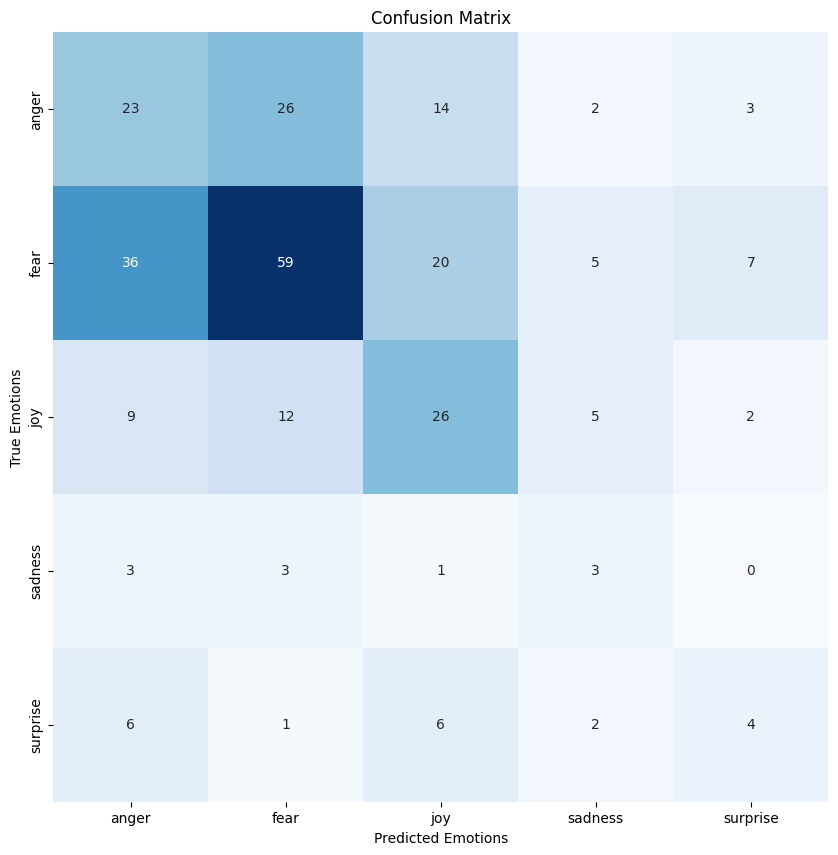

In [36]:
# Generate the prediction matrix in the plot
def plot_confusion_matrix(y_true, y_pred, emotions):
    
    # Defining the confusion matrix
    cm = confusion_matrix(y_true, y_pred) 
    
    # Plotting the confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=emotions, yticklabels=emotions)
    plt.xlabel("Predicted Emotions")
    plt.ylabel("True Emotions")
    plt.title("Confusion Matrix")

# Plotting the confusion matrix
plot_confusion_matrix(y_test.argmax(axis=1), classifier_preds.argmax(axis=1), emotion)


# Using Logistic Regression

In [42]:
# Similarly use the Logistic Regression classifier for multi-label classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lc = LogisticRegression(max_iter=1000)
classifier = MultiOutputClassifier(lc, n_jobs=-1)
classifier.fit(X_train, y_train)

# Making predictions on Emotions
classifier_preds = classifier.predict(X_test)
classifier_preds

# Model evaluation
model_eval(y_test, classifier_preds, emotion)



C:\Users\Prerana\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Prerana\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Precision,Recall,F1
anger,0.00,0.00,0.00
fear,0.64,0.84,0.72
joy,0.80,0.13,0.22
sadness,0.54,0.18,0.27
surprise,0.75,0.17,0.28
MACRO-AVERAGE,0.55,0.26,0.30


# Checking Logistic regression model accuracy

In [41]:
#calculate the model accuracy
accuracy = accuracy_score(y_test, classifier_preds)
print("The model accuracy is: ", accuracy)

The model accuracy is:  0.21942446043165467


# Using Random Forest

In [43]:
# Similarly use the Random Forest classifier for multi-label classification
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
classifier = MultiOutputClassifier(rf, n_jobs=-1)
classifier.fit(X_train, y_train)

# Making predictions on Emotions
classifier_preds = classifier.predict(X_test)
classifier_preds

# Model evaluation
model_eval(y_test, classifier_preds, emotion)


,Precision,Recall,F1
anger,0.40,0.11,0.17
fear,0.66,0.75,0.71
joy,0.58,0.34,0.43
sadness,0.48,0.29,0.36
surprise,0.54,0.30,0.39
MACRO-AVERAGE,0.53,0.36,0.41


# Checking Random Forest model accuracy

In [44]:
# #calculate the model accuracy
accuracy = accuracy_score(y_test, classifier_preds)
print("The model accuracy is: ", accuracy)


The model accuracy is:  0.2302158273381295


In [45]:
# comparision of the models using the model evaluation function
# Ridge Classifier
rc = RidgeClassifier(class_weight='balanced')
classifier = MultiOutputClassifier(rc, n_jobs=-1)
classifier.fit(X_train, y_train)
classifier_preds = classifier.predict(X_test)
print("Ridge Classifier")
print(model_eval(y_test, classifier_preds, emotion))
print()

# Logistic Regression
lc = LogisticRegression(max_iter=1000)
classifier = MultiOutputClassifier(lc, n_jobs=-1)
classifier.fit(X_train, y_train)
classifier_preds = classifier.predict(X_test)
print("Logistic Regression")
print(model_eval(y_test, classifier_preds, emotion))
print()

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
classifier = MultiOutputClassifier(rf, n_jobs=-1)
classifier.fit(X_train, y_train)
classifier_preds = classifier.predict(X_test)
print("Random Forest")
print(model_eval(y_test, classifier_preds, emotion))
print()



Ridge Classifier
               Precision  Recall    F1
anger               0.23    0.34  0.28
fear                0.70    0.62  0.66
joy                 0.42    0.63  0.50
sadness             0.47    0.62  0.54
surprise            0.49    0.62  0.54
MACRO-AVERAGE       0.46    0.57  0.50

Logistic Regression
               Precision  Recall    F1
anger               0.00    0.00  0.00
fear                0.64    0.84  0.72
joy                 0.80    0.13  0.22
sadness             0.54    0.18  0.27
surprise            0.75    0.17  0.28
MACRO-AVERAGE       0.55    0.26  0.30



C:\Users\Prerana\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Prerana\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest
               Precision  Recall    F1
anger               0.40    0.11  0.17
fear                0.66    0.75  0.71
joy                 0.58    0.34  0.43
sadness             0.48    0.29  0.36
surprise            0.54    0.30  0.39
MACRO-AVERAGE       0.53    0.36  0.41



C:\Users\Prerana\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Prerana\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


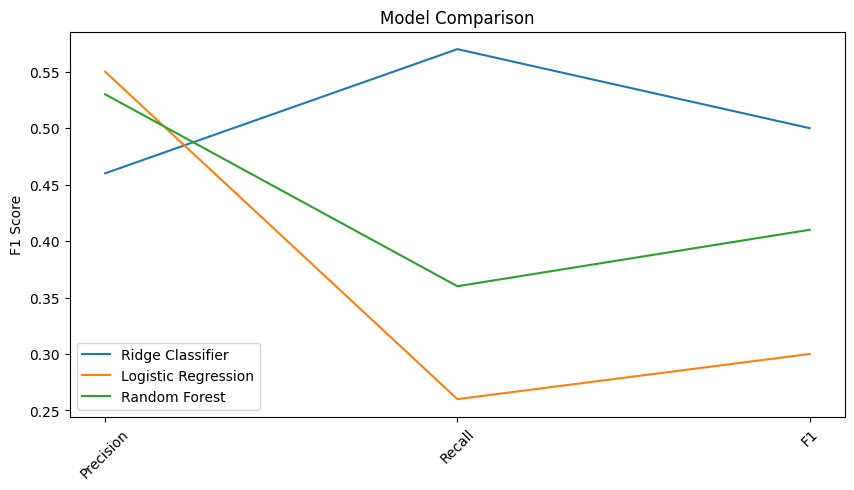

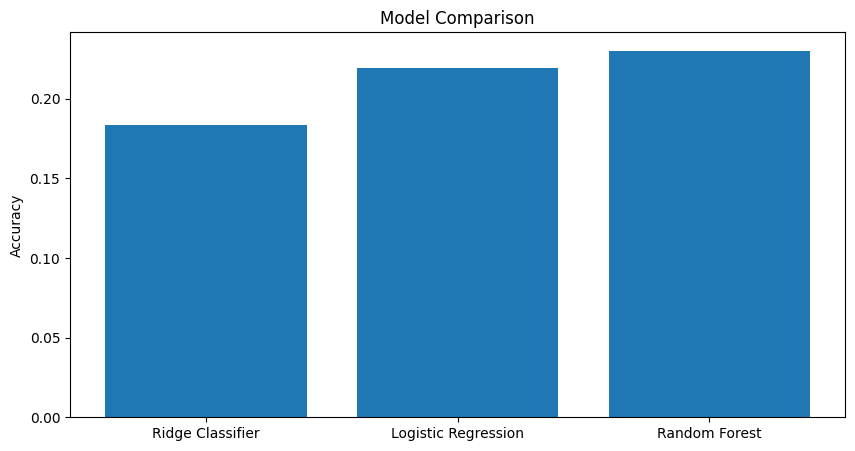

In [63]:
# simple graph to see the comparision of the models
# Ridge Classifier
rc = RidgeClassifier(class_weight='balanced')
classifier = MultiOutputClassifier(rc, n_jobs=-1)
classifier.fit(X_train, y_train)
classifier_preds = classifier.predict(X_test)
rc_results = model_eval(y_test, classifier_preds, emotion).iloc[-1]

# Logistic Regression
lc = LogisticRegression(max_iter=1000)
classifier = MultiOutputClassifier(lc, n_jobs=-1)
classifier.fit(X_train, y_train)
classifier_preds = classifier.predict(X_test)
lc_results = model_eval(y_test, classifier_preds, emotion).iloc[-1]

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
classifier = MultiOutputClassifier(rf, n_jobs=-1)
classifier.fit(X_train, y_train)
classifier_preds = classifier.predict(X_test)
rf_results = model_eval(y_test, classifier_preds, emotion).iloc[-1]

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(rc_results, label="Ridge Classifier")
plt.plot(lc_results, label="Logistic Regression")
plt.plot(rf_results, label="Random Forest")
plt.xticks(rotation=45)
plt.title("Model Comparison")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

# also use the model accuracy to compare the models
# Ridge Classifier
rc = RidgeClassifier(class_weight='balanced')
classifier = MultiOutputClassifier(rc, n_jobs=-1)
classifier.fit(X_train, y_train)
classifier_preds = classifier.predict(X_test)
rc_accuracy = accuracy_score(y_test, classifier_preds)

# Logistic Regression
lc = LogisticRegression(max_iter=1000)
classifier = MultiOutputClassifier(lc, n_jobs=-1)
classifier.fit(X_train, y_train)
classifier_preds = classifier.predict(X_test)
lc_accuracy = accuracy_score(y_test, classifier_preds)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
classifier = MultiOutputClassifier(rf, n_jobs=-1)
classifier.fit(X_train, y_train)
classifier_preds = classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, classifier_preds)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.bar(["Ridge Classifier", "Logistic Regression", "Random Forest"], [rc_accuracy, lc_accuracy, rf_accuracy])
plt.title("Model Comparison")
plt.ylabel("Accuracy")
plt.show()


Making predictions

In [47]:
# Retrieving initial text preprocessings
def preprocess_data(x):

    # Adding a space between words and punctation
    x = re.sub( r'([a-zA-Z\[\]])([,;.!?])', r'\1 \2', x)
    x = re.sub( r'([,;.!?])([a-zA-Z\[\]])', r'\1 \2', x)

    # Demojize
    x = emoji.demojize(x)

    # Expand contraction
    x = contractions.fix(x)

    # Lower
    x = x.lower()

    #correct some acronyms/typos/abbreviations
    x = re.sub(r"lmao", "laughing my ass off", x)
    x = re.sub(r"amirite", "am i right", x)
    x = re.sub(r"\b(tho)\b", "though", x)
    x = re.sub(r"\b(ikr)\b", "i know right", x)
    x = re.sub(r"\b(ya|u)\b", "you", x)
    x = re.sub(r"\b(eu)\b", "europe", x)
    x = re.sub(r"\b(da)\b", "the", x)
    x = re.sub(r"\b(dat)\b", "that", x)
    x = re.sub(r"\b(dats)\b", "that is", x)
    x = re.sub(r"\b(cuz)\b", "because", x)
    x = re.sub(r"\b(fkn)\b", "fucking", x)
    x = re.sub(r"\b(tbh)\b", "to be honest", x)
    x = re.sub(r"\b(tbf)\b", "to be fair", x)
    x = re.sub(r"faux pas", "mistake", x)
    x = re.sub(r"\b(btw)\b", "by the way", x)
    x = re.sub(r"\b(bs)\b", "bullshit", x)
    x = re.sub(r"\b(kinda)\b", "kind of", x)
    x = re.sub(r"\b(bruh)\b", "bro", x)
    x = re.sub(r"\b(w/e)\b", "whatever", x)
    x = re.sub(r"\b(w/)\b", "with", x)
    x = re.sub(r"\b(w/o)\b", "without", x)
    x = re.sub(r"\b(doj)\b", "department of justice", x)

    # replace some words with multiple occurences of a letter, example "coooool" turns into --> cool
    x = re.sub(r"\b(j+e{2,}z+e*)\b", "jeez", x)
    x = re.sub(r"\b(co+l+)\b", "cool", x)
    x = re.sub(r"\b(g+o+a+l+)\b", "goal", x)
    x = re.sub(r"\b(s+h+i+t+)\b", "shit", x)
    x = re.sub(r"\b(o+m+g+)\b", "omg", x)
    x = re.sub(r"\b(w+t+f+)\b", "wtf", x)
    x = re.sub(r"\b(w+h+a+t+)\b", "what", x)
    x = re.sub(r"\b(y+e+y+|y+a+y+|y+e+a+h+)\b", "yeah", x)
    x = re.sub(r"\b(w+o+w+)\b", "wow", x)
    x = re.sub(r"\b(w+h+y+)\b", "why", x)
    x = re.sub(r"\b(s+o+)\b", "so", x)
    x = re.sub(r"\b(f)\b", "fuck", x)
    x = re.sub(r"\b(w+h+o+p+s+)\b", "whoops", x)
    x = re.sub(r"\b(ofc)\b", "of course", x)
    x = re.sub(r"\b(the us)\b", "usa", x)
    x = re.sub(r"\b(gf)\b", "girlfriend", x)
    x = re.sub(r"\b(hr)\b", "human ressources", x)
    x = re.sub(r"\b(mh)\b", "mental health", x)
    x = re.sub(r"\b(idk)\b", "i do not know", x)
    x = re.sub(r"\b(gotcha)\b", "i got you", x)
    x = re.sub(r"\b(y+e+p+)\b", "yes", x)
    x = re.sub(r"\b(a*ha+h[ha]*|a*ha +h[ha]*)\b", "haha", x)
    x = re.sub(r"\b(o?l+o+l+[ol]*)\b", "lol", x)
    x = re.sub(r"\b(o*ho+h[ho]*|o*ho +h[ho]*)\b", "ohoh", x)
    x = re.sub(r"\b(o+h+)\b", "oh", x)
    x = re.sub(r"\b(a+h+)\b", "ah", x)
    x = re.sub(r"\b(u+h+)\b", "uh", x)

    # Handling emojis
    x = re.sub(r"<3", " love ", x)
    x = re.sub(r"xd", " smiling_face_with_open_mouth_and_tightly_closed_eyes ", x)
    x = re.sub(r":\)", " smiling_face ", x)
    x = re.sub(r"^_^", " smiling_face ", x)
    x = re.sub(r"\*_\*", " star_struck ", x)
    x = re.sub(r":\(", " frowning_face ", x)
    x = re.sub(r":\^\(", " frowning_face ", x)
    x = re.sub(r";\(", " frowning_face ", x)
    x = re.sub(r":\/",  " confused_face", x)
    x = re.sub(r";\)",  " wink", x)
    x = re.sub(r">__<",  " unamused ", x)
    x = re.sub(r"\b([xo]+x*)\b", " xoxo ", x)
    x = re.sub(r"\b(n+a+h+)\b", "no", x)

    # Handling special cases of text
    x = re.sub(r"h a m b e r d e r s", "hamberders", x)
    x = re.sub(r"b e n", "ben", x)
    x = re.sub(r"s a t i r e", "satire", x)
    x = re.sub(r"y i k e s", "yikes", x)
    x = re.sub(r"s p o i l e r", "spoiler", x)
    x = re.sub(r"thankyou", "thank you", x)
    x = re.sub(r"a^r^o^o^o^o^o^o^o^n^d", "around", x)

    # Remove special characters and numbers replace by space + remove double space
    x = re.sub(r"\b([.]{3,})"," dots ", x)
    x = re.sub(r"[^A-Za-z!?_]+"," ", x)
    x = re.sub(r"\b([s])\b *","", x)
    x = re.sub(r" +"," ", x)
    x = x.strip()

    return x

In [48]:
def predict_samples(text_samples, model):

    # Text preprocessing and cleaning
    text_samples = pd.Series(text_samples)
    text_samples_clean = text_samples.apply(preprocess_data)

    # Create tfidf representation
    tfidf_text_samples_clean = vectorizer.transform(text_samples_clean)

    # labels predictions
    samples_pred_labels = model.predict(tfidf_text_samples_clean)
    samples_pred_labels_df = pd.DataFrame(samples_pred_labels)
    samples_pred_labels_df = samples_pred_labels_df.apply(lambda x: [emotion[i] for i in range(len(x)) if x[i]==1], axis=1)

    return pd.DataFrame({"Text":text_samples, "Emotions":list(samples_pred_labels_df)})

Evaluation and Prediction testing

In [49]:
# Predict samples
predict_samples("Was it about my model?", classifier)

,Text,Emotions
0,Was it about my model?,[fear]


In [50]:
# Predict samples for paragraph
text_samples = ["I am so happy today", "I am feeling very sad", "I am feeling very angry", "I am feeling very surprised", "I am feeling very fearful"]
predict_samples(text_samples, classifier)



,Text,Emotions
0,I am so happy today,"[joy, sadness]"
1,I am feeling very sad,"[fear, sadness]"
2,I am feeling very angry,"[anger, fear]"
3,I am feeling very surprised,[fear]
4,I am feeling very fearful,[fear]
